In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Model
import numpy as np

In [2]:
BATCH_SIZE = 64
MAX_VOCAB_SIZE = 10000  
SEQUENCE_LENGTH = 50

In [4]:
EMBED_DIM = 128     
NUM_HEADS = 4       
FF_DIM = 256        
DROPOUT = 0.1       
EPOCHS = 30

In [5]:
df = pd.read_csv('cleaned_hieroglyphs_data.csv')
df['gardiner_sequence'] = df['gardiner_sequence'].astype(str)
df['english_translation'] = df['english_translation'].astype(str)
df

,gardiner_sequence,english_translation
0,D21 Q3 D36 F4 D36 L2 X1 S19 S29 U23 T21 X1 G17...,"hereditary noble and prince , royal seal-beare..."
1,M17 A26 S34 Aa1 G43 A1 Z3 h N17 N23 A1 Z2B S29...,"o living ones , who are upon the earth , who s..."
2,W24 V31 V22 F34 N35 M23 X1 N35 G17 R8 O6 X1 O1...,i was a trusted one of the king in the temple ...
3,G35 F34 F34 F34 D2 Z1 Aa17 U6 D21 M17 M17 X1 N...,"a trusted one upon the landing place , great o..."
4,M17 G43 D4 N35 M17 M40 O34 O1 Z1 G17 V28 W14 X...,i built a tomb through the favour of the king ...
...,...,...
30722,D2 Z1 N25 X1 Z1 V28 D36 N35 G40 G43 X1 Aa1 D56 A2,in/on the desert and the refugee
30723,D35A N35 E34 N35 D58 N37 X1 G43 D40 Z2 G17 O4 ...,in your time there should be no uprising .
30724,G36 D21 A21 N35 F4 V31,the great ones will fall because of your strength
30725,O4 G17 O4 G17 A2 Z2 V31 W19 M17 O4 O4 Q7 N35 F...,your war cry follows like the glowing breath o...


In [6]:
source_vectorization = TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH,
)

In [7]:
target_vectorization = TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH + 1,
)

In [8]:
source_vectorization.adapt(df['gardiner_sequence'].values)
target_vectorization.adapt(df['english_translation'].values)

In [9]:
def format_dataset(source, target):
    source = source_vectorization(source)
    target = target_vectorization(target)
    return ({
        "encoder_inputs": source,
        "decoder_inputs": target[:, :-1], 
    }, target[:, 1:])

In [10]:
def make_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df['gardiner_sequence'], df['english_translation']))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()

In [11]:
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

In [12]:
train_ds = make_dataset(train_df)
val_ds = make_dataset(val_df)

In [13]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

In [14]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None: mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [15]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        attention_output_1 = self.attention_1(inputs, inputs, use_causal_mask=True)
        out_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(out_1, encoder_outputs)
        out_2 = self.layernorm_2(out_1 + attention_output_2)
        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

In [16]:
encoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(SEQUENCE_LENGTH, MAX_VOCAB_SIZE, EMBED_DIM)(encoder_inputs)
encoder_outputs = TransformerEncoder(EMBED_DIM, FF_DIM, NUM_HEADS)(x)

In [17]:
decoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
x = PositionalEmbedding(SEQUENCE_LENGTH, MAX_VOCAB_SIZE, EMBED_DIM)(decoder_inputs)
x = TransformerDecoder(EMBED_DIM, FF_DIM, NUM_HEADS)(x, encoder_outputs)
x = layers.Dropout(DROPOUT)(x)
decoder_outputs = layers.Dense(MAX_VOCAB_SIZE, activation="softmax")(x)

In [18]:
transformer_model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

transformer_model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

transformer_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 128) │  1,286,400 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 128) │  1,286,400 │ decoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 128) │    330,240 │ positional_embed… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decoder │ (None, None, 128) │    594,304 │ positional_embed… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, None, 128) │          0 │ transformer_deco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, None,      │  1,290,000 │ dropout_3[0][0]   │
│                     │ 10000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,787,344 (18.26 MB)

 Trainable params: 4,787,344 (18.26 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = transformer_model.fit(
    train_ds, 
    epochs=EPOCHS, 
    validation_data=val_ds
)

Epoch 1/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 353s 889ms/step - accuracy: 0.7946 - loss: 1.7357 - val_accuracy: 0.8110 - val_loss: 1.2328
Epoch 2/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 348s 905ms/step - accuracy: 0.8180 - loss: 1.1486 - val_accuracy: 0.8202 - val_loss: 1.1191
Epoch 3/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 355s 922ms/step - accuracy: 0.8278 - loss: 1.0402 - val_accuracy: 0.8286 - val_loss: 1.0455
Epoch 4/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 356s 924ms/step - accuracy: 0.8353 - loss: 0.9608 - val_accuracy: 0.8333 - val_loss: 0.9967
Epoch 5/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 355s 922ms/step - accuracy: 0.8424 - loss: 0.8916 - val_accuracy: 0.8382 - val_loss: 0.9561
Epoch 6/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 350s 909ms/step - accuracy: 0.8487 - loss: 0.8319 - val_accuracy: 0.8412 - val_loss: 0.9250
Epoch 7/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 353s 916ms/step - accuracy: 0.8538 - loss: 0.7825 - val_accuracy: 0.8440 - val_loss: 0.9052
Epoch 8/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 352s 916ms/step - accuracy: 0.8585 -

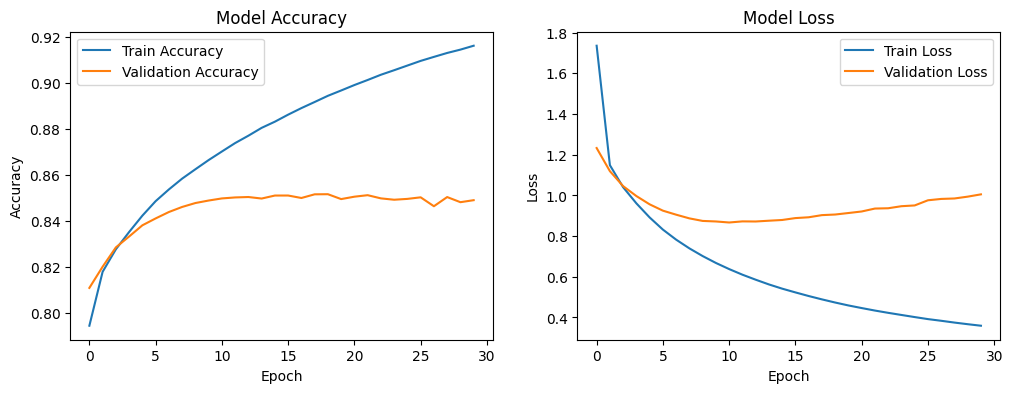

In [20]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
transformer_model.save('hieroglyph_transformer.keras')
print("Model saved successfully as 'hieroglyph_transformer.keras'")

Model saved successfully as 'hieroglyph_transformer.keras'
